In [2]:
!pip install -q python-igraph scikit-learn ripser persim

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.3/841.3 kB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 2.2 MB/s eta 0:00:00


In [3]:
import torch
from torch.utils.data import Subset
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt

# Define the transformation pipeline:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x > 0.5).float()),  # Binarize the image
    transforms.Lambda(lambda x: x.view(-1))           # Flatten into a 784-dim vector
])

# Load the training set (set download=True if running for the first time)
mnist_train = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Get indices for images where the label is 1
indices = (mnist_train.targets == 1).nonzero().squeeze()

# Create a subset containing only the '1's
mnist_train_ones = Subset(mnist_train, indices)

print(f"Total number of '1' images in the training set: {len(mnist_train_ones)}")

# Stack all 784-dim vectors from the filtered dataset
all_vectors = torch.stack([img for img, _ in mnist_train_ones])
unique_vectors = torch.unique(all_vectors, dim=0)

print(f"Total images in mnist_train_ones: {all_vectors.shape[0]}")
print(f"Unique images: {unique_vectors.shape[0]}")

if all_vectors.shape[0] == unique_vectors.shape[0]:
    print("All 784-dimensional vectors are unique.")
else:
    print("There are duplicates in the 784-dimensional vectors.")



100%|██████████| 9.91M/9.91M [00:00<00:00, 201MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 31.5MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 78.8MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 1.40MB/s]


Total number of '1' images in the training set: 6742
Total images in mnist_train_ones: 6742
Unique images: 6726
There are duplicates in the 784-dimensional vectors.


In [4]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
import igraph as ig

def visualize_k_nearest_neighbors_graph(unique_vectors, k):
    """
    Builds an unweighted graph with python-igraph where each unique vector is a node.
    Each node is connected to its k nearest neighbors (excluding itself).

    Args:
        unique_vectors (torch.Tensor or np.array): Array/tensor of shape (n, d) containing feature vectors.
        k (int): Number of nearest neighbors for each node.

    Returns:
        g (igraph.Graph): The constructed unweighted graph.
    """
    # Convert tensor to numpy array if necessary.
    if hasattr(unique_vectors, 'numpy'):
        X = unique_vectors.numpy()
    else:
        X = unique_vectors

    n = X.shape[0]
    print(f"Building unweighted k-NN graph for {n} nodes...")

    # Find k nearest neighbors for each node. Note: The first neighbor is the point itself.
    nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='auto').fit(X)
    distances, indices = nbrs.kneighbors(X)

    edge_list = []
    for i, neigh in enumerate(indices):
        # Skip the first neighbor (self) and add undirected edges only once.
        for j in neigh[1:]:
            if i < j:
                edge_list.append((i, j))

    # Create an undirected graph.
    g = ig.Graph(n=n, edges=edge_list, directed=False)
    print(f"Unweighted k-NN graph built with {len(edge_list)} edges.")
    return g

g = visualize_k_nearest_neighbors_graph(unique_vectors, 5)


Building unweighted k-NN graph for 6726 nodes...
Unweighted k-NN graph built with 15285 edges.


In [5]:
def build_filtered_knn_graph(unique_vectors, k, max_distance=6.0):
    if hasattr(unique_vectors, 'numpy'):
        X = unique_vectors.numpy()
    else:
        X = unique_vectors

    n = X.shape[0]
    print(f"Building filtered k-NN graph for {n} nodes with edge dist ≤ {max_distance}...")

    nbrs = NearestNeighbors(n_neighbors=k+1).fit(X)
    distances, indices = nbrs.kneighbors(X)

    edge_list = []
    for i, (neighbors, dists) in enumerate(zip(indices, distances)):
        for j, dist in zip(neighbors[1:], dists[1:]):  # skip self (index 0)
            if dist <= max_distance and i < j:
                edge_list.append((i, j))

    g = ig.Graph(n=n, edges=edge_list, directed=False)
    print(f"Filtered k-NN graph built with {len(edge_list)} edges.")
    return g

threshold = 6
g_thresh = build_filtered_knn_graph(unique_vectors, k=5, max_distance=threshold)


Building filtered k-NN graph for 6726 nodes with edge dist ≤ 6...
Filtered k-NN graph built with 15068 edges.


In [6]:
components = g_thresh.clusters()
largest_component_index = components.sizes().index(max(components.sizes()))
g_largest = g_thresh.subgraph(components[largest_component_index])
mapping = components[largest_component_index]  # Maps subgraph idx → original idx
print(f"Largest component: {g_largest.vcount()} nodes, {g_largest.ecount()} edges.")


Largest component: 6372 nodes, 15015 edges.


<ipython-input-6-1dcb5f0051b5>:1: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  components = g_thresh.clusters()


In [7]:
dist_matrix = g_largest.shortest_paths()
dist_matrix = np.array(dist_matrix)
max_dist = np.max(dist_matrix)
i, j = np.unravel_index(np.argmax(dist_matrix), dist_matrix.shape)
print(f"Furthest nodes: {i} and {j} with shortest path length {max_dist}")


<ipython-input-7-9fed582e627f>:1: DeprecationWarning: Graph.shortest_paths() is deprecated; use Graph.distances() instead
  dist_matrix = g_largest.shortest_paths()


Furthest nodes: 0 and 6339 with shortest path length 38


In [8]:
# Get the shortest path (as list of node indices)
path = g_largest.get_shortest_paths(i, to=j, output='vpath')[0]

# Reuse original vectors for distance calculation
vectors_np = unique_vectors.numpy()
path_distances = []

for idx in range(len(path) - 1):
    u, v = path[idx], path[idx + 1]
    vec_u = vectors_np[mapping[u]]
    vec_v = vectors_np[mapping[v]]
    dist = np.linalg.norm(vec_u - vec_v)
    path_distances.append(dist)
    print(f"Edge {u} -> {v} | L2 distance: {dist:.4f}")

total_path_distance = sum(path_distances)
print(f"\nTotal L2 distance along path: {total_path_distance:.4f}")


Edge 0 -> 1 | L2 distance: 5.9161
Edge 1 -> 116 | L2 distance: 4.8990
Edge 116 -> 108 | L2 distance: 4.5826
Edge 108 -> 2304 | L2 distance: 4.7958
Edge 2304 -> 2384 | L2 distance: 4.2426
Edge 2384 -> 125 | L2 distance: 4.3589
Edge 125 -> 26 | L2 distance: 5.3852
Edge 26 -> 364 | L2 distance: 5.2915
Edge 364 -> 2664 | L2 distance: 4.8990
Edge 2664 -> 2806 | L2 distance: 5.0000
Edge 2806 -> 557 | L2 distance: 4.6904
Edge 557 -> 849 | L2 distance: 4.5826
Edge 849 -> 842 | L2 distance: 4.3589
Edge 842 -> 1199 | L2 distance: 4.3589
Edge 1199 -> 1182 | L2 distance: 3.7417
Edge 1182 -> 1109 | L2 distance: 3.6056
Edge 1109 -> 1103 | L2 distance: 3.7417
Edge 1103 -> 1549 | L2 distance: 3.7417
Edge 1549 -> 1472 | L2 distance: 4.3589
Edge 1472 -> 1833 | L2 distance: 4.1231
Edge 1833 -> 2208 | L2 distance: 3.7417
Edge 2208 -> 2197 | L2 distance: 3.7417
Edge 2197 -> 5690 | L2 distance: 3.8730
Edge 5690 -> 6186 | L2 distance: 2.4495
Edge 6186 -> 5691 | L2 distance: 3.6056
Edge 5691 -> 6142 | L2 dist

In [9]:
for idx in range(len(path) - 1):
    u, v = path[idx], path[idx + 1]
    vec_u = vectors_np[u]
    vec_v = vectors_np[v]
    direction = vec_v - vec_u

    print(f"\nEdge {u} -> {v}:")
    print("l(t) = u + t * (v - u), where t ∈ [0, 1]")
    print(f"u (start): {vec_u[:5]} ...")  # print only first 5 dims
    print(f"v (end):   {vec_v[:5]} ...")
    print(f"v - u:     {direction[:5]} ...")



Edge 0 -> 1:
l(t) = u + t * (v - u), where t ∈ [0, 1]
u (start): [0. 0. 0. 0. 0.] ...
v (end):   [0. 0. 0. 0. 0.] ...
v - u:     [0. 0. 0. 0. 0.] ...

Edge 1 -> 116:
l(t) = u + t * (v - u), where t ∈ [0, 1]
u (start): [0. 0. 0. 0. 0.] ...
v (end):   [0. 0. 0. 0. 0.] ...
v - u:     [0. 0. 0. 0. 0.] ...

Edge 116 -> 108:
l(t) = u + t * (v - u), where t ∈ [0, 1]
u (start): [0. 0. 0. 0. 0.] ...
v (end):   [0. 0. 0. 0. 0.] ...
v - u:     [0. 0. 0. 0. 0.] ...

Edge 108 -> 2304:
l(t) = u + t * (v - u), where t ∈ [0, 1]
u (start): [0. 0. 0. 0. 0.] ...
v (end):   [0. 0. 0. 0. 0.] ...
v - u:     [0. 0. 0. 0. 0.] ...

Edge 2304 -> 2384:
l(t) = u + t * (v - u), where t ∈ [0, 1]
u (start): [0. 0. 0. 0. 0.] ...
v (end):   [0. 0. 0. 0. 0.] ...
v - u:     [0. 0. 0. 0. 0.] ...

Edge 2384 -> 125:
l(t) = u + t * (v - u), where t ∈ [0, 1]
u (start): [0. 0. 0. 0. 0.] ...
v (end):   [0. 0. 0. 0. 0.] ...
v - u:     [0. 0. 0. 0. 0.] ...

Edge 125 -> 26:
l(t) = u + t * (v - u), where t ∈ [0, 1]
u (start): [0.

In [10]:
import numpy as np

# Step 1: Get the actual vectors for start and end
vec_start = vectors_np[mapping[path[0]]]
vec_end   = vectors_np[mapping[path[-1]]]

# Step 2: Compute linear interpolated points at t = 0.05, 0.10, ..., 0.95
ts = np.linspace(0.05, 0.95, 19)
linear_interp_vectors = [(1 - t) * vec_start + t * vec_end for t in ts]

# Step 3: Compute cumulative distances along the real graph path
graph_vectors = [vectors_np[mapping[node]] for node in path]
cum_dists = [0.0]
for i in range(1, len(graph_vectors)):
    dist = np.linalg.norm(graph_vectors[i] - graph_vectors[i-1])
    cum_dists.append(cum_dists[-1] + dist)

total_graph_distance = cum_dists[-1]
total_linear_distance = np.linalg.norm(vec_end - vec_start)
print(f"Total real graph distance: {total_graph_distance:.4f}")
print(f"Total linear distance:     {total_linear_distance:.4f}")

# Step 4: Get graph vectors at approximately matching 5% points
graph_interp_vectors = []
for target_frac in ts:
    target_dist = target_frac * total_graph_distance
    # Find the first segment that passes the target distance
    for i in range(1, len(cum_dists)):
        if cum_dists[i] >= target_dist:
            graph_interp_vectors.append(graph_vectors[i])
            break

# Step 5: Compare each pair of vectors
direction = vec_end - vec_start
direction = direction / np.linalg.norm(direction)

print("t\tL2 deviation\tcos(angle to direction)")
for t, lin_vec, graph_vec in zip(ts, linear_interp_vectors, graph_interp_vectors):
    delta = graph_vec - lin_vec
    l2 = np.linalg.norm(delta)
    cos_angle = np.dot(delta, direction) / (np.linalg.norm(delta) + 1e-9)
    print(f"{t:.2f}\t{l2:.4f}\t\t{cos_angle:.4f}")



Total real graph distance: 158.5491
Total linear distance:     10.7238
t	L2 deviation	cos(angle to direction)
0.05	6.6248		0.1161
0.10	7.9215		0.0647
0.15	8.2394		0.0198
0.20	8.5790		0.0217
0.25	9.3374		-0.0275
0.30	9.4419		-0.0247
0.35	9.4439		-0.0321
0.40	9.4763		0.0098
0.45	9.1317		-0.0077
0.50	9.3140		-0.0551
0.55	9.0104		-0.0750
0.60	8.8204		-0.1163
0.65	8.9212		-0.1542
0.70	8.3756		-0.1392
0.75	7.9804		-0.2132
0.80	7.4699		-0.1748
0.85	6.9848		-0.2503
0.90	6.4459		-0.3110
0.95	4.4707		-0.1512


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


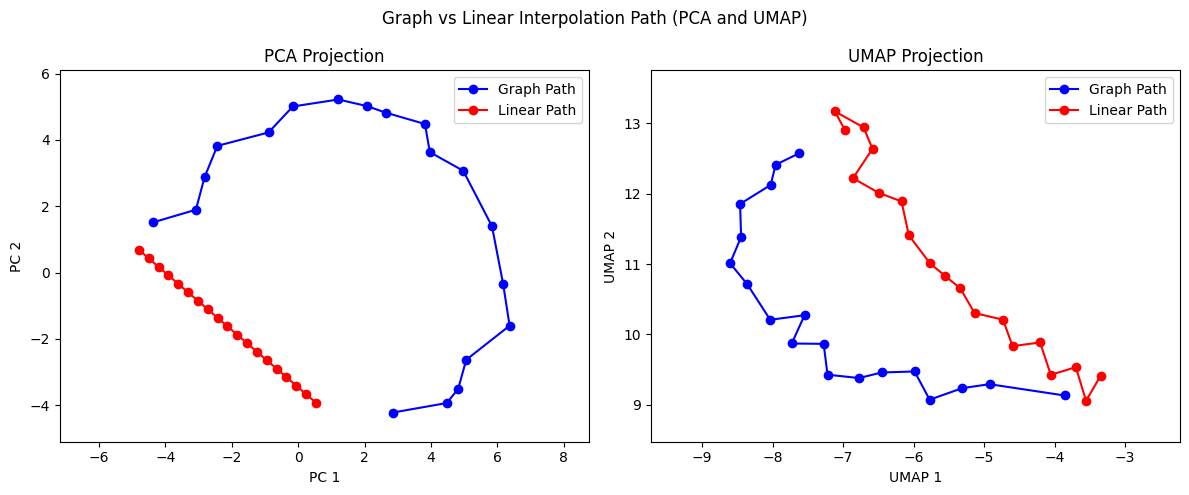

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import umap

# Assume you already have:
# - graph_interp_vectors (list of graph path vectors)
# - linear_interp_vectors (list of linearly interpolated vectors)

# Stack them together for joint projection
all_vectors = np.stack(graph_interp_vectors + linear_interp_vectors)  # shape (2N, 784)

# ---------- PCA ----------
pca = PCA(n_components=2)
all_pca = pca.fit_transform(all_vectors)
graph_pca = all_pca[:len(graph_interp_vectors)]
linear_pca = all_pca[len(graph_interp_vectors):]

# ---------- UMAP ----------
reducer = umap.UMAP(n_components=2, random_state=42)
all_umap = reducer.fit_transform(all_vectors)
graph_umap = all_umap[:len(graph_interp_vectors)]
linear_umap = all_umap[len(graph_interp_vectors):]

# ---------- Plotting ----------
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# ----- PCA Plot -----
axs[0].plot(graph_pca[:, 0], graph_pca[:, 1], '-o', label='Graph Path', color='blue')
axs[0].plot(linear_pca[:, 0], linear_pca[:, 1], '-o', label='Linear Path', color='red')
axs[0].set_title("PCA Projection")
axs[0].set_xlabel("PC 1")
axs[0].set_ylabel("PC 2")
axs[0].axis('equal')
axs[0].legend()

# ----- UMAP Plot -----
axs[1].plot(graph_umap[:, 0], graph_umap[:, 1], '-o', label='Graph Path', color='blue')
axs[1].plot(linear_umap[:, 0], linear_umap[:, 1], '-o', label='Linear Path', color='red')
axs[1].set_title("UMAP Projection")
axs[1].set_xlabel("UMAP 1")
axs[1].set_ylabel("UMAP 2")
axs[1].axis('equal')
axs[1].legend()

plt.suptitle("Graph vs Linear Interpolation Path (PCA and UMAP)")
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


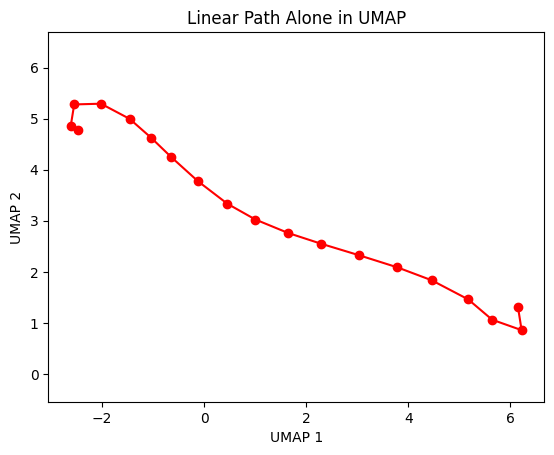

In [12]:
linear_np = np.stack(linear_interp_vectors)
reducer = umap.UMAP(n_neighbors=5, random_state=42)
linear_umap_alone = reducer.fit_transform(linear_np)

plt.plot(linear_umap_alone[:, 0], linear_umap_alone[:, 1], '-o', color='red')
plt.title("Linear Path Alone in UMAP")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.axis('equal')
plt.show()


In [13]:
import numpy as np

direction = vec_end - vec_start
unit_direction = direction / np.linalg.norm(direction)

print(f"{'t':<6}{'Along (scalar)':<20}{'Deviation (L2)':<20}")
print("-" * 50)

for t, graph_vec in zip(ts, graph_interp_vectors):
    # Step 1: vector from start to this graph point
    vector_to_point = graph_vec - vec_start

    # Step 2: how far along the line is this point?
    parallel_scalar = np.dot(vector_to_point, unit_direction)

    # Step 3: reconstruct the "shadow" on the line - where does the graph node fall on the line
    projection_point = vec_start + parallel_scalar * unit_direction

    # Step 4: measure the sideways offset (how far off the line)
    deviation_vector = graph_vec - projection_point
    deviation_distance = np.linalg.norm(deviation_vector)

    print(f"{t:<6.2f}{parallel_scalar:<20.4f}{deviation_distance:<20.4f}")


t     Along (scalar)      Deviation (L2)      
--------------------------------------------------
0.05  1.3055              6.5799              
0.10  1.5853              7.9049              
0.15  1.7718              8.2378              
0.20  2.3313              8.5770              
0.25  2.4245              9.3339              
0.30  2.9840              9.4390              
0.35  3.4503              9.4390              
0.40  4.3828              9.4758              
0.45  4.7558              9.1314              
0.50  4.8490              9.2998              
0.55  5.2220              8.9850              
0.60  5.4085              8.7606              
0.65  5.5950              8.8145              
0.70  6.3410              8.2941              
0.75  6.3410              7.7969              
0.80  7.2735              7.3550              
0.85  7.3668              6.7624              
0.90  7.6465              6.1262              
0.95  9.5115              4.4193              


In [14]:
import numpy as np

# Step 1: Compute normalized direction vectors between points
directions = []
for i in range(len(graph_interp_vectors) - 1):
    diff = graph_interp_vectors[i+1] - graph_interp_vectors[i]
    norm = np.linalg.norm(diff)
    directions.append(diff / norm if norm > 0 else diff)

# Step 2: Compute angle between consecutive directions
angles = []
for i in range(len(directions) - 1):
    dot = np.dot(directions[i], directions[i+1])
    dot = np.clip(dot, -1.0, 1.0)  # to avoid numerical issues
    angle = np.arccos(dot)  # in radians
    angles.append(np.degrees(angle))  # convert to degrees for readability

# Step 3: Print the results
print(f"{'Segment':<10}{'Turning angle (deg)':<20}")
print("-" * 30)
for i, angle in enumerate(angles):
    print(f"{i:<10}{angle:<20.2f}")


Segment   Turning angle (deg) 
------------------------------
0         104.48              
1         109.11              
2         116.05              
3         102.79              
4         96.40               
5         96.04               
6         98.36               
7         114.22              
8         90.00               
9         104.53              
10        99.86               
11        95.90               
12        93.61               
13        93.13               
14        97.68               
15        99.86               
16        107.11              


In [15]:
def plot_curvature_path_pca_umap(path, vectors_np, title_prefix="Plot"):
    import matplotlib.pyplot as plt
    from sklearn.decomposition import PCA
    import umap

    # Extract path vectors
    path_vectors = vectors_np[path]
    full_data = vectors_np

    combined = np.vstack((full_data, path_vectors))
    offset = full_data.shape[0]
    path_indices_in_combined = np.arange(offset, offset + len(path))

    # PCA and UMAP
    pca = PCA(n_components=2)
    pca_embed = pca.fit_transform(combined)
    path_pca = pca_embed[path_indices_in_combined]

    reducer = umap.UMAP(n_components=2, random_state=42)
    umap_embed = reducer.fit_transform(combined)
    path_umap = umap_embed[path_indices_in_combined]

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    for i, (embedding, path_embedding, title) in enumerate([
        (pca_embed, path_pca, "PCA"),
        (umap_embed, path_umap, "UMAP")
    ]):
        ax = axs[i]
        ax.scatter(embedding[:, 0], embedding[:, 1], s=5, alpha=0.3, label="All Points")
        ax.plot(path_embedding[:, 0], path_embedding[:, 1], '-o', color='black', linewidth=2, label="Path")

        # Start point = blue
        ax.scatter(path_embedding[0, 0], path_embedding[0, 1], color='blue', s=100, label='Start', zorder=5)
        ax.text(path_embedding[0, 0], path_embedding[0, 1], "Start", fontsize=8, color='blue')

        # End point = red
        ax.scatter(path_embedding[-1, 0], path_embedding[-1, 1], color='red', s=100, label='End', zorder=5)
        ax.text(path_embedding[-1, 0], path_embedding[-1, 1], "End", fontsize=8, color='red')

        ax.set_title(f"{title_prefix} ({title})")
        ax.axis('equal')
        ax.legend()

    plt.tight_layout()
    plt.show()


<ipython-input-16-c327b04f7b44>:14: DeprecationWarning: Graph.shortest_paths() is deprecated; use Graph.distances() instead
  dists_from_u = g.shortest_paths(source=u)[0]
<ipython-input-16-c327b04f7b44>:18: DeprecationWarning: Graph.shortest_paths() is deprecated; use Graph.distances() instead
  dists_from_v = g.shortest_paths(source=v)[0]


Estimated diameter: 38
Farthest nodes found: 6339 -> 0
Path length: 39


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


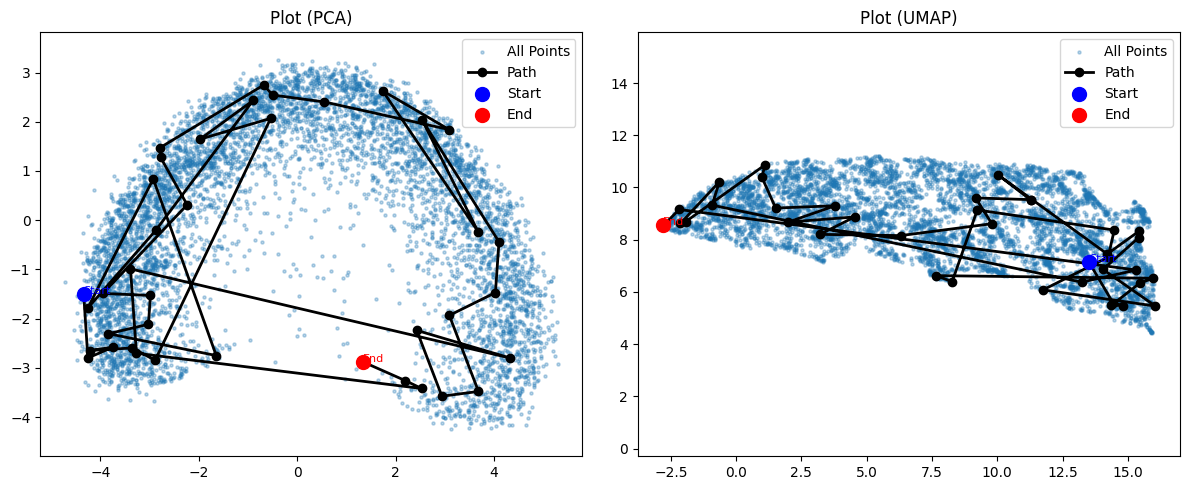

In [16]:
import numpy as np
import random

def estimate_diameter_fast(g, num_trials=10):
    max_dist = -1
    best_pair = (None, None)
    best_path = []

    for _ in range(num_trials):
        # 1. Pick a random starting node
        u = random.randint(0, g.vcount() - 1)

        # 2. First sweep: find the farthest node from u
        dists_from_u = g.shortest_paths(source=u)[0]
        v = int(np.argmax(dists_from_u))

        # 3. Second sweep: find the farthest node from v
        dists_from_v = g.shortest_paths(source=v)[0]
        w = int(np.argmax(dists_from_v))
        dist_vw = dists_from_v[w]

        # 4. Save if this is the longest so far
        if dist_vw > max_dist:
            max_dist = dist_vw
            best_pair = (v, w)
            best_path = g.get_shortest_paths(v, to=w, output='vpath')[0]

    print(f"Estimated diameter: {max_dist}")
    print(f"Farthest nodes found: {best_pair[0]} -> {best_pair[1]}")
    print(f"Path length: {len(best_path)}")
    return best_pair, best_path, max_dist

pair, path, dist = estimate_diameter_fast(g_largest, num_trials=10)
plot_curvature_path_pca_umap(path, vectors_np, title_prefix="Plot")

Most curved path found:
 - Nodes: (652, 2665)
 - Graph hops: 16
 - L2 distance: 5.2915
 - Curvature score: 3.0237


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


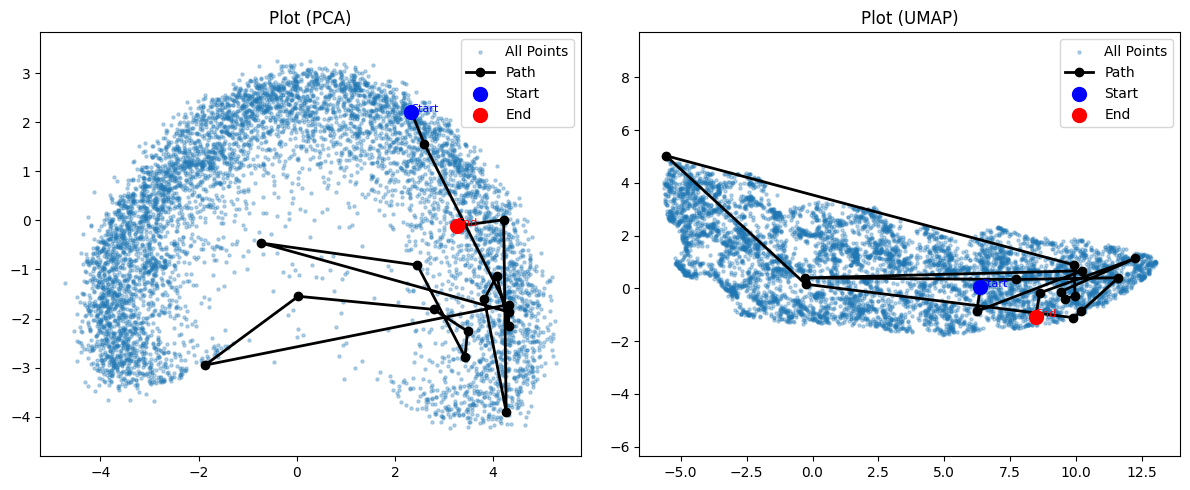

In [17]:
import numpy as np
import random

def find_high_curvature_paths(g, vectors_np, num_samples=100):
    best_score = -1
    best_pair = (None, None)
    best_path = []

    n = g.vcount()

    for _ in range(num_samples):
        # Random pair of distinct nodes
        u, v = random.sample(range(n), 2)

        # Graph distance (number of hops)
        try:
            path = g.get_shortest_paths(u, to=v, output='vpath')[0]
        except:
            continue  # skip if no path (disconnected)
        graph_len = len(path) - 1

        if graph_len == 0:
            continue

        # L2 distance in 784D
        vec_u = vectors_np[u]
        vec_v = vectors_np[v]
        l2_dist = np.linalg.norm(vec_u - vec_v)

        if l2_dist == 0:
            continue

        # Curvature score: how bendy is the path vs straight line
        score = graph_len / l2_dist

        if score > best_score:
            best_score = score
            best_pair = (u, v)
            best_path = path

    print(f"Most curved path found:")
    print(f" - Nodes: {best_pair}")
    print(f" - Graph hops: {len(best_path) - 1}")
    print(f" - L2 distance: {np.linalg.norm(vectors_np[best_pair[0]] - vectors_np[best_pair[1]]):.4f}")
    print(f" - Curvature score: {best_score:.4f}")

    return best_pair, best_path, best_score

pair, path, score = find_high_curvature_paths(g_largest, vectors_np, num_samples=100)
plot_curvature_path_pca_umap(path, vectors_np, title_prefix="Plot")

Greedy curvature path length: 30
Node indices: [4656, 4444, 5342, 4701, 4878, 4903, 5460, 5184, 5215, 5190, 5208, 5202, 5234, 5010, 5092, 5389, 5386, 5400, 5796, 5621, 2010, 2029, 1980, 1760, 1984, 1957, 1773, 2042, 2040, 2182]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


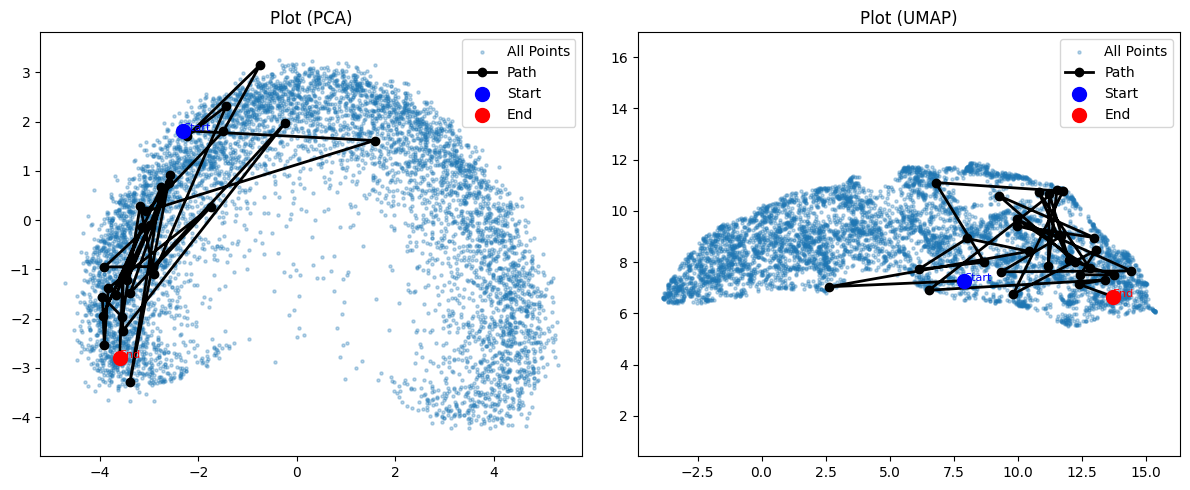

In [18]:
import numpy as np
import random

def angle_between(u, v):
    dot = np.dot(u, v)
    dot = np.clip(dot, -1.0, 1.0)  # numerical stability
    return np.arccos(dot)

def greedy_curvature_walk(g, vectors_np, walk_length=20):
    n = g.vcount()
    visited = set()

    # 1. Random starting node
    path = [random.randint(0, n - 1)]
    visited.add(path[0])

    while len(path) < walk_length:
        current = path[-1]
        neighbors = [v for v in g.neighbors(current) if v not in visited]
        if not neighbors:
            break  # dead end

        if len(path) == 1:
            # First step: just pick farthest neighbor by L2
            cur_vec = vectors_np[current]
            next_node = max(neighbors, key=lambda v: np.linalg.norm(vectors_np[v] - cur_vec))
        else:
            # Compute turning angles
            prev_vec = vectors_np[path[-2]]
            cur_vec = vectors_np[current]
            prev_dir = cur_vec - prev_vec
            prev_dir /= np.linalg.norm(prev_dir)

            def turning_angle(v):
                next_vec = vectors_np[v]
                new_dir = next_vec - cur_vec
                new_dir /= np.linalg.norm(new_dir)
                return angle_between(prev_dir, new_dir)

            # Pick neighbor with **largest turning angle**
            next_node = max(neighbors, key=turning_angle)

        path.append(next_node)
        visited.add(next_node)

    print(f"Greedy curvature path length: {len(path)}")
    print(f"Node indices: {path}")
    return path
curved_path = greedy_curvature_walk(g_largest, vectors_np, walk_length=30)
plot_curvature_path_pca_umap(curved_path, vectors_np)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


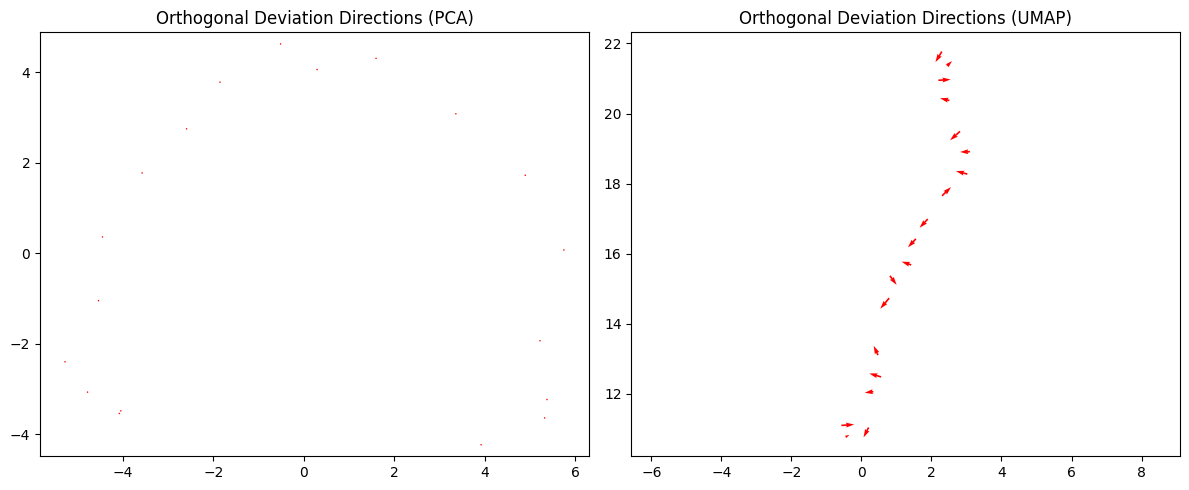

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import umap

def plot_deviation_directions(graph_interp_vectors, linear_interp_vectors, u, v):
    graph = np.stack(graph_interp_vectors)
    linear = np.stack(linear_interp_vectors)
    d = v - u
    d_unit = d / np.linalg.norm(d)

    # Project graph points onto the line
    projections = []
    deviation_vectors = []

    for g in graph:
        g_rel = g - u
        proj_scalar = np.dot(g_rel, d_unit)
        proj_point = u + proj_scalar * d_unit
        projections.append(proj_point)

        deviation = g - proj_point
        deviation_vectors.append(deviation)

    projections = np.stack(projections)
    deviation_vectors = np.stack(deviation_vectors)
    # return projections, deviation_vectors

    # Combine all for PCA/UMAP
    full = np.vstack([graph, projections])
    pca = PCA(n_components=2).fit_transform(full)
    reducer = umap.UMAP(n_components=2, random_state=42)
    umap_embed = reducer.fit_transform(full)

    n = len(graph)
    pca_graph = pca[:n]
    pca_proj = pca[n:]
    umap_graph = umap_embed[:n]
    umap_proj = umap_embed[n:]

    # Arrows = graph point to its projection
    pca_arrows = pca_graph - pca_proj
    umap_arrows = umap_graph - umap_proj

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    for i, (pos, arrows, name) in enumerate([
        (pca_proj, pca_arrows, "PCA"),
        (umap_proj, umap_arrows, "UMAP")
    ]):
        ax = axs[i]
        ax.quiver(pos[:, 0], pos[:, 1],
                  arrows[:, 0], arrows[:, 1],
                  angles='xy', scale_units='xy', scale=1, color='red', width=0.003)
        ax.set_title(f"Orthogonal Deviation Directions ({name})")
        ax.axis('equal')

    plt.tight_layout()
    plt.show()
plot_deviation_directions(graph_interp_vectors, linear_interp_vectors, u, v)


(19, 784)
PC1 explains 40.6719% of deviation variance
PC2 explains 20.6017% of deviation variance
PC3 explains 9.6591% of deviation variance
PC4 explains 5.9488% of deviation variance
PC5 explains 3.1767% of deviation variance
PC6 explains 2.7450% of deviation variance
PC7 explains 2.5695% of deviation variance
PC8 explains 2.3289% of deviation variance
PC9 explains 2.0665% of deviation variance
PC10 explains 1.8754% of deviation variance
PC11 explains 1.6417% of deviation variance
PC12 explains 1.3051% of deviation variance
PC13 explains 1.0976% of deviation variance
PC14 explains 1.0549% of deviation variance
PC15 explains 0.9793% of deviation variance
PC16 explains 0.8767% of deviation variance
PC17 explains 0.7895% of deviation variance
PC18 explains 0.6116% of deviation variance
PC19 explains 0.0000% of deviation variance


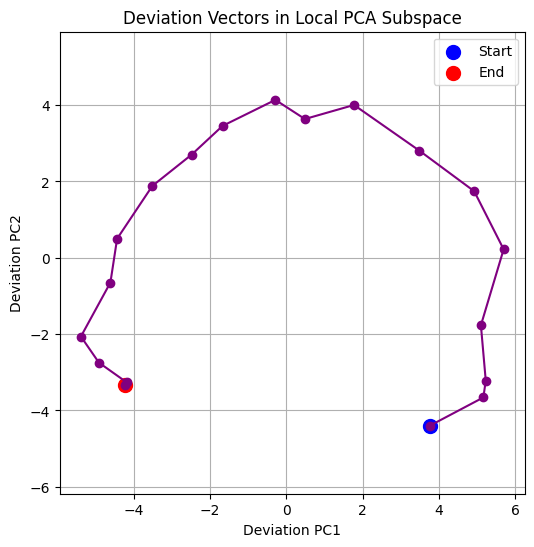

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def pca_on_deviation_vectors(graph_interp_vectors, linear_interp_vectors, u, v):
    graph = np.stack(graph_interp_vectors)
    linear = np.stack(linear_interp_vectors)
    d = v - u
    d_unit = d / np.linalg.norm(d)

    # Compute projections of graph points onto the line
    projections = []
    deviation_vectors = []
    for g in graph:
        rel = g - u
        proj_scalar = np.dot(rel, d_unit)
        proj = u + proj_scalar * d_unit
        projections.append(proj)
        deviation_vectors.append(g - proj)

    deviation_vectors = np.stack(deviation_vectors)
    print(deviation_vectors.shape)

    # Run PCA on deviation vectors
    pca = PCA()
    pca_dev_coords = pca.fit_transform(deviation_vectors)
    for i, var in enumerate(pca.explained_variance_ratio_):
        print(f"PC{i+1} explains {var * 100:.4f}% of deviation variance")


    # Plot the 2D curve traced by deviation directions
    plt.figure(figsize=(6, 6))
    plt.plot(pca_dev_coords[:, 0], pca_dev_coords[:, 1], '-o', color='purple')
    plt.scatter(pca_dev_coords[0, 0], pca_dev_coords[0, 1], color='blue', label='Start', s=100)
    plt.scatter(pca_dev_coords[-1, 0], pca_dev_coords[-1, 1], color='red', label='End', s=100)
    plt.title("Deviation Vectors in Local PCA Subspace")
    plt.xlabel("Deviation PC1")
    plt.ylabel("Deviation PC2")
    plt.axis('equal')
    plt.legend()
    plt.grid(True)
    plt.show()

    return pca_dev_coords

pca_deviation_coords = pca_on_deviation_vectors(
    graph_interp_vectors,
    linear_interp_vectors,
    vectors_np[path[0]],
    vectors_np[path[-1]]
)


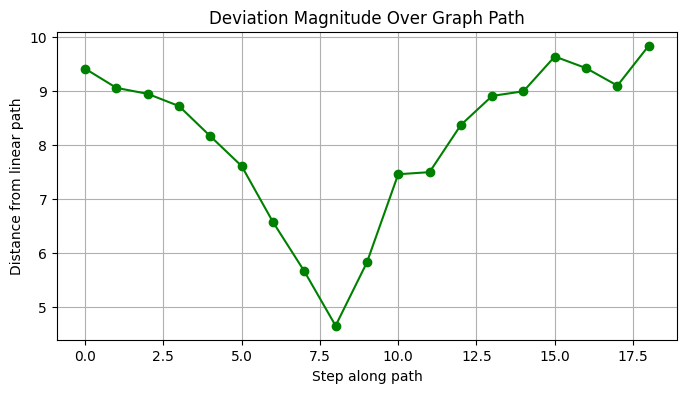

[np.float32(9.41693),
 np.float32(9.061299),
 np.float32(8.950259),
 np.float32(8.723941),
 np.float32(8.165695),
 np.float32(7.613428),
 np.float32(6.576473),
 np.float32(5.666316),
 np.float32(4.6560254),
 np.float32(5.8278885),
 np.float32(7.4618073),
 np.float32(7.5),
 np.float32(8.373001),
 np.float32(8.912271),
 np.float32(8.998015),
 np.float32(9.641799),
 np.float32(9.426407),
 np.float32(9.102591),
 np.float32(9.841602)]

In [21]:
import numpy as np
import matplotlib.pyplot as plt

def plot_deviation_norms(graph_interp_vectors, linear_interp_vectors, u, v):
    graph = np.stack(graph_interp_vectors)
    linear = np.stack(linear_interp_vectors)
    d = v - u
    d_unit = d / np.linalg.norm(d)

    deviation_norms = []
    for g in graph:
        rel = g - u
        proj_scalar = np.dot(rel, d_unit)
        proj = u + proj_scalar * d_unit
        deviation_vector = g - proj
        deviation_norms.append(np.linalg.norm(deviation_vector))

    # Plot the curvature (deviation norm) profile
    plt.figure(figsize=(8, 4))
    plt.plot(deviation_norms, marker='o', color='green')
    plt.title("Deviation Magnitude Over Graph Path")
    plt.xlabel("Step along path")
    plt.ylabel("Distance from linear path")
    plt.grid(True)
    plt.show()

    return deviation_norms
plot_deviation_norms(
    graph_interp_vectors,
    linear_interp_vectors,
    vectors_np[path[0]],
    vectors_np[path[-1]]
)



Step 1 | Current dim: 784
  Keeping 35 components to retain 80% variance


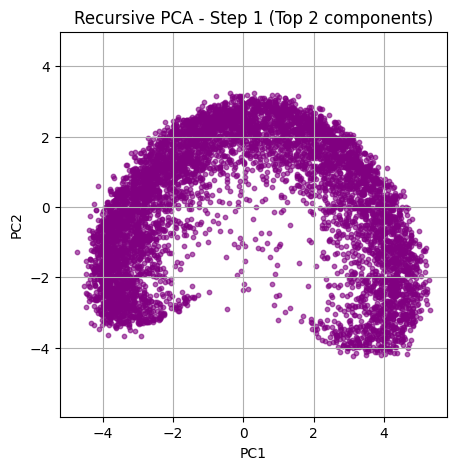


Step 2 | Current dim: 35
  Keeping 10 components to retain 80% variance


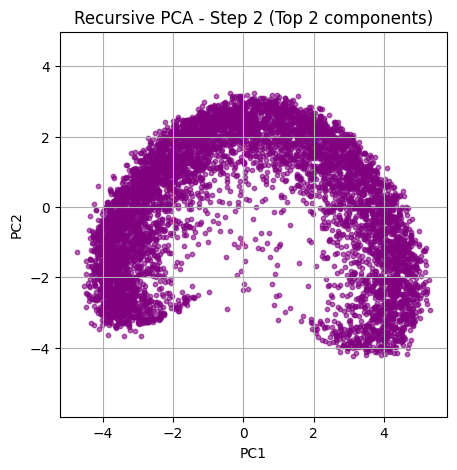


Step 3 | Current dim: 10
  Keeping 5 components to retain 80% variance


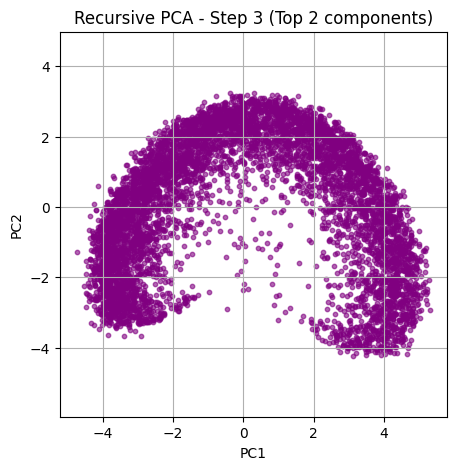


Step 4 | Current dim: 5
  Keeping 3 components to retain 80% variance


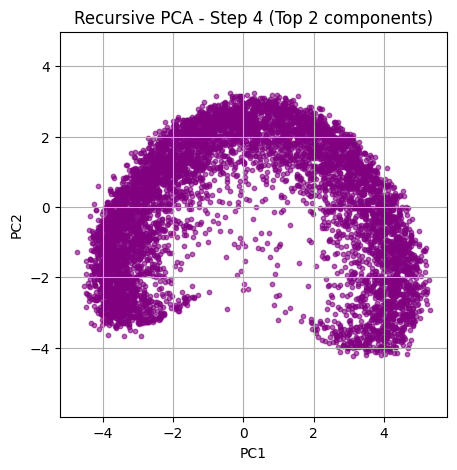


Step 5 | Current dim: 3
  Keeping 2 components to retain 80% variance


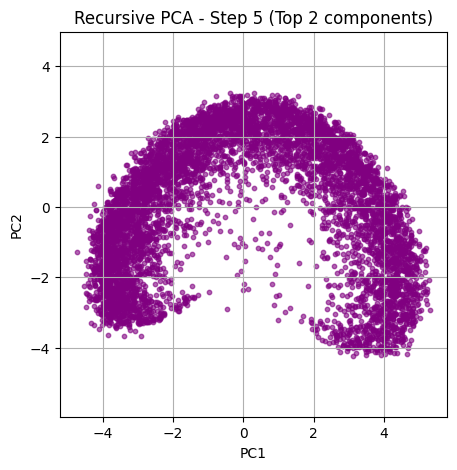

'\ndoesnt really work because it keeps picking the same 2 components DUH\n'

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def recursive_pca(data, target_dims=2, variance_cutoff=0.80, max_steps=20):
    """
    Recursively apply PCA, retaining only components that explain a given fraction of variance.
    Plot the 2D projection at each stage.

    Args:
        data: numpy array of shape (n_samples, n_features)
        target_dims: stop recursion once we reach this dimensionality
        variance_cutoff: how much variance to retain at each step (e.g. 0.80)
        max_steps: max recursion steps
    """
    current_data = data.copy()
    step = 0

    while current_data.shape[1] > target_dims and step < max_steps:
        print(f"\nStep {step+1} | Current dim: {current_data.shape[1]}")
        pca = PCA()
        projected = pca.fit_transform(current_data)
        cumulative = np.cumsum(pca.explained_variance_ratio_)
        num_components = np.searchsorted(cumulative, variance_cutoff) + 1
        print(f"  Keeping {num_components} components to retain {variance_cutoff*100:.0f}% variance")

        # Visualize 2D projection of top 2 components
        plt.figure(figsize=(5, 5))
        plt.scatter(projected[:, 0], projected[:, 1], s=10, alpha=0.6, color='purple')
        plt.title(f"Recursive PCA - Step {step+1} (Top 2 components)")
        plt.xlabel("PC1")
        plt.ylabel("PC2")
        plt.axis('equal')
        plt.grid(True)
        plt.show()

        # Reduce dimensionality for next step
        pca_reduced = PCA(n_components=num_components)
        current_data = pca_reduced.fit_transform(current_data)
        step += 1
recursive_pca(vectors_np, target_dims=2, variance_cutoff=0.80)
'''
doesnt really work because it keeps picking the same 2 components DUH
'''

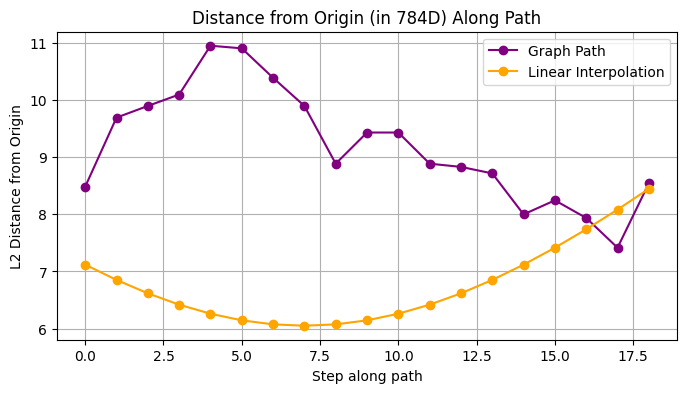

"\nso the linear path is a curve which tells us approximately it's on a curved manifold and the line cuts through it\nand the graph is bumpy but generally further away from the origin. so in general we know\nthat the manifold is further away on the edges of the 784d space\n"

In [23]:
import numpy as np
import matplotlib.pyplot as plt

def plot_distance_from_origin(graph_interp_vectors, linear_interp_vectors):
    graph = np.stack(graph_interp_vectors)
    linear = np.stack(linear_interp_vectors)

    graph_dists = np.linalg.norm(graph, axis=1)
    linear_dists = np.linalg.norm(linear, axis=1)

    steps = np.arange(len(graph))

    plt.figure(figsize=(8, 4))
    plt.plot(steps, graph_dists, '-o', label='Graph Path', color='purple')
    plt.plot(steps, linear_dists, '-o', label='Linear Interpolation', color='orange')
    plt.title("Distance from Origin (in 784D) Along Path")
    plt.xlabel("Step along path")
    plt.ylabel("L2 Distance from Origin")
    plt.legend()
    plt.grid(True)
    plt.show()
plot_distance_from_origin(graph_interp_vectors, linear_interp_vectors)
'''
so the linear path is a curve which tells us approximately it's on a curved manifold and the line cuts through it
and the graph is bumpy but generally further away from the origin. so in general we know
that the manifold is further away on the edges of the 784d space
'''

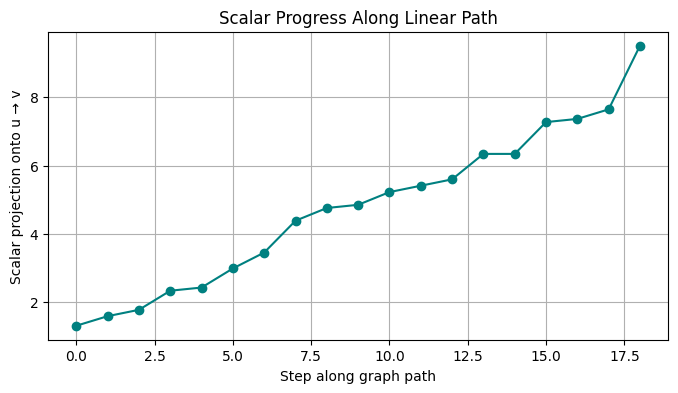

In [24]:
import numpy as np
import matplotlib.pyplot as plt

def plot_scalar_progress(graph_interp_vectors, u, v):
    graph = np.stack(graph_interp_vectors)
    d = v - u
    d_unit = d / np.linalg.norm(d)

    # Compute scalar projection for each graph point onto line u → v
    scalars = [(g - u) @ d_unit for g in graph]

    plt.figure(figsize=(8, 4))
    plt.plot(scalars, '-o', color='teal')
    plt.title("Scalar Progress Along Linear Path")
    plt.xlabel("Step along graph path")
    plt.ylabel("Scalar projection onto u → v")
    plt.grid(True)
    plt.show()

    return scalars
s_values = plot_scalar_progress(graph_interp_vectors, vec_start, vec_end)


PCA variance explained by direction vectors:
PC1: 33.8193%
PC2: 29.7692%
PC3: 10.0322%
PC4: 8.2380%
PC5: 3.8525%
PC6: 2.6943%
PC7: 1.5116%
PC8: 1.2817%
PC9: 1.1182%
PC10: 1.0864%


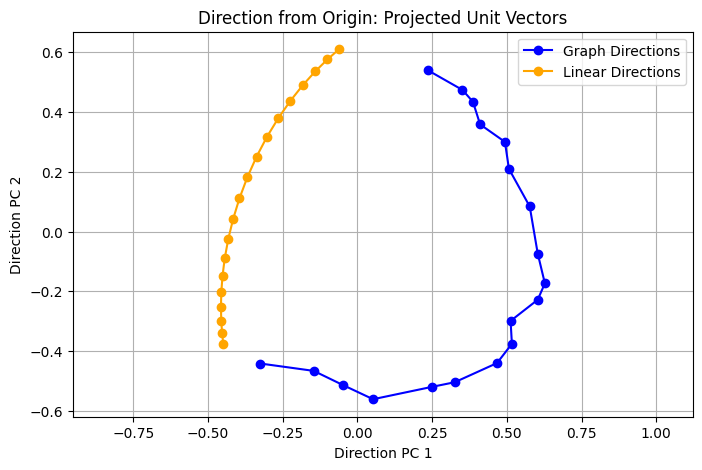

'\nhigh pca explained variance more than likely because of linear path not graph path\n'

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def plot_direction_trajectory(graph_interp_vectors, linear_interp_vectors):
    graph = np.stack(graph_interp_vectors)
    linear = np.stack(linear_interp_vectors)

    # Normalize to unit vectors (directions from origin)
    graph_dirs = graph / np.linalg.norm(graph, axis=1, keepdims=True)
    linear_dirs = linear / np.linalg.norm(linear, axis=1, keepdims=True)

    # Combine for joint PCA projection
    all_dirs = np.vstack([graph_dirs, linear_dirs])
    pca = PCA()
    proj = pca.fit_transform(all_dirs)

    # Print explained variance of first 10 components
    print("PCA variance explained by direction vectors:")
    for i, var in enumerate(pca.explained_variance_ratio_[:10]):
        print(f"PC{i+1}: {var * 100:.4f}%")

    n = len(graph_dirs)
    graph_proj = proj[:n]
    linear_proj = proj[n:]

    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(graph_proj[:, 0], graph_proj[:, 1], '-o', label='Graph Directions', color='blue')
    plt.plot(linear_proj[:, 0], linear_proj[:, 1], '-o', label='Linear Directions', color='orange')
    plt.title("Direction from Origin: Projected Unit Vectors")
    plt.xlabel("Direction PC 1")
    plt.ylabel("Direction PC 2")
    plt.axis('equal')
    plt.grid(True)
    plt.legend()
    plt.show()
plot_direction_trajectory(graph_interp_vectors, linear_interp_vectors)

'''
high pca explained variance more than likely because of linear path not graph path
'''

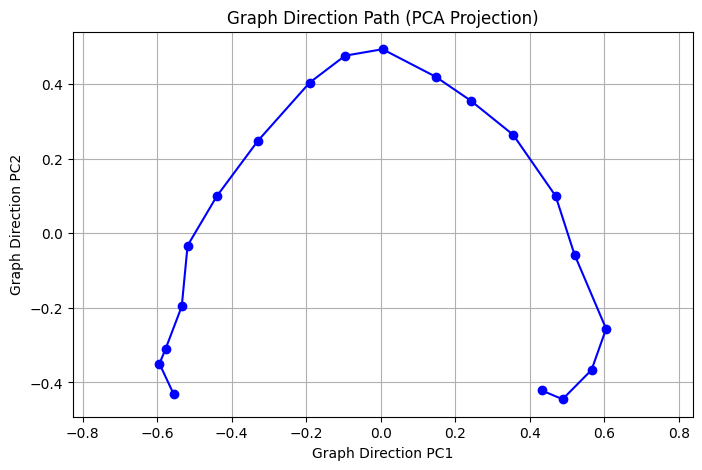

PCA variance explained by graph direction vectors:
PC1: 39.1079%
PC2: 22.3285%
PC3: 10.4334%
PC4: 5.3573%
PC5: 3.3343%
PC6: 2.8151%
PC7: 2.4916%
PC8: 2.1619%
PC9: 2.0211%
PC10: 1.8815%


In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def plot_graph_direction_pca(graph_interp_vectors):
    graph = np.stack(graph_interp_vectors)

    # Normalize graph vectors to unit length (direction from origin)
    graph_dirs = graph / np.linalg.norm(graph, axis=1, keepdims=True)

    # Run PCA on the graph directions only
    pca = PCA(n_components=10)
    graph_proj = pca.fit_transform(graph_dirs)

    # Plot the first two components
    plt.figure(figsize=(8, 5))
    plt.plot(graph_proj[:, 0], graph_proj[:, 1], '-o', color='blue')
    plt.title("Graph Direction Path (PCA Projection)")
    plt.xlabel("Graph Direction PC1")
    plt.ylabel("Graph Direction PC2")
    plt.grid(True)
    plt.axis('equal')
    plt.show()

    # Print variance explained
    print("PCA variance explained by graph direction vectors:")
    for i, var in enumerate(pca.explained_variance_ratio_[:10]):
        print(f"PC{i+1}: {var * 100:.4f}%")

    return graph_proj, pca
graph_dir_proj, graph_dir_pca = plot_graph_direction_pca(graph_interp_vectors)


(7, 784)


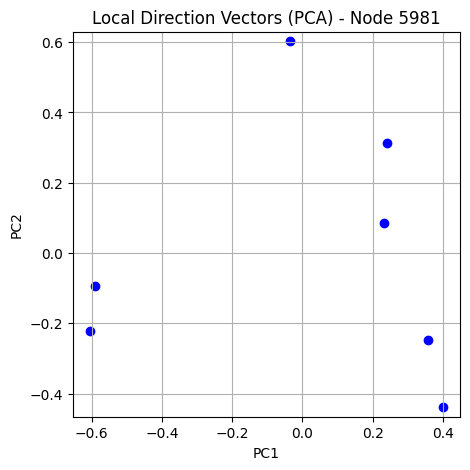

Explained variance:
PC1: 33.5323%
PC2: 23.5900%
PC3: 16.3265%
PC4: 11.4528%
PC5: 8.5480%


In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def get_neighbor_directions(vectors_np, g, node_index):
    neighbors = g.neighbors(node_index)
    center = vectors_np[node_index]
    directions = []

    for nb in neighbors:
        vec = vectors_np[nb] - center
        unit_dir = vec / np.linalg.norm(vec)
        directions.append(unit_dir)

    directions = np.stack(directions)  # shape: (k, 784)
    return directions, neighbors

def plot_local_direction_pca(directions, node_index):
    pca = PCA()
    proj = pca.fit_transform(directions)

    plt.figure(figsize=(5, 5))
    plt.scatter(proj[:, 0], proj[:, 1], color='blue')
    plt.title(f"Local Direction Vectors (PCA) - Node {node_index}")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid(True)
    plt.axis('equal')
    plt.show()

    # Variance explained
    print("Explained variance:")
    for i, var in enumerate(pca.explained_variance_ratio_[:5]):
        print(f"PC{i+1}: {var * 100:.4f}%")

    return proj, pca

random_node = np.random.randint(len(vectors_np))
dirs, neighbors = get_neighbor_directions(vectors_np, g_largest, random_node)
print(dirs.shape)
proj, pca_model = plot_local_direction_pca(dirs, random_node)


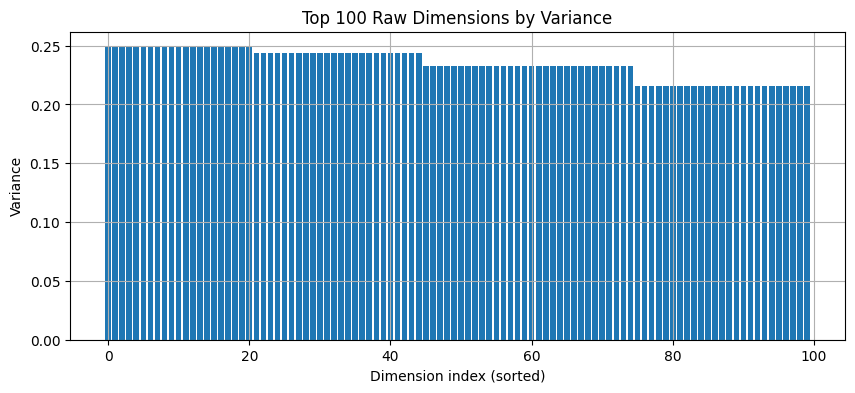

In [30]:
import numpy as np
import matplotlib.pyplot as plt

def plot_raw_dimension_variance(vectors, top_n=20):
    """
    Plot the variance along each of the 784 original dimensions.
    """
    # Stack vectors into (N, 784)
    all_vecs = np.stack(vectors)  # can be graph_interp_vectors, unique_vectors, etc.

    # Compute variance along each dimension
    variances = np.var(all_vecs, axis=0)

    # Sort by magnitude
    sorted_idx = np.argsort(variances)[::-1]
    sorted_variances = variances[sorted_idx]

    # Plot top N
    plt.figure(figsize=(10, 4))
    plt.bar(range(top_n), sorted_variances[:top_n])
    plt.title(f"Top {top_n} Raw Dimensions by Variance")
    plt.xlabel("Dimension index (sorted)")
    plt.ylabel("Variance")
    plt.grid(True)
    plt.show()

    return sorted_idx, sorted_variances

top_dims, variances = plot_raw_dimension_variance(graph_interp_vectors, top_n=100)


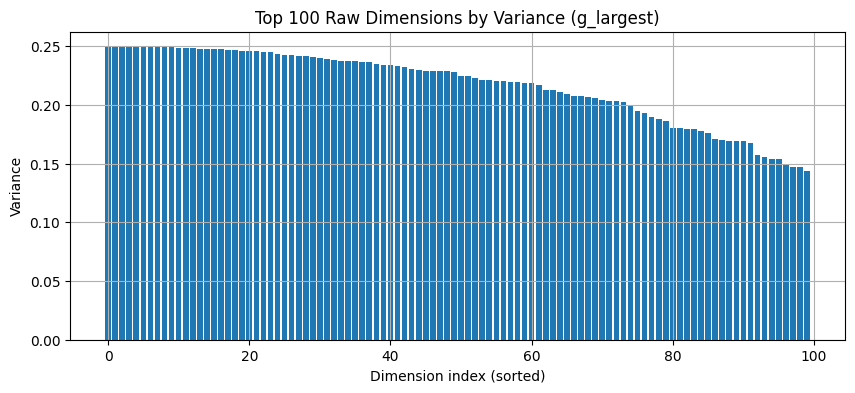

In [31]:
def plot_graph_largest_dimension_variance(g_largest, vectors_np, top_n=30):
    """
    Compute and plot variance per dimension across all nodes in g_largest.
    """
    node_indices = g_largest.vs.indices  # node IDs in global indexing
    selected_vectors = vectors_np[node_indices]  # (N, 784)

    # Compute variance along each dimension
    variances = np.var(selected_vectors, axis=0)

    # Sort by variance
    sorted_idx = np.argsort(variances)[::-1]
    sorted_variances = variances[sorted_idx]

    # Plot
    plt.figure(figsize=(10, 4))
    plt.bar(range(top_n), sorted_variances[:top_n])
    plt.title(f"Top {top_n} Raw Dimensions by Variance (g_largest)")
    plt.xlabel("Dimension index (sorted)")
    plt.ylabel("Variance")
    plt.grid(True)
    plt.show()

    return sorted_idx, sorted_variances
top_dims, variances = plot_graph_largest_dimension_variance(g_largest, vectors_np, top_n=100)


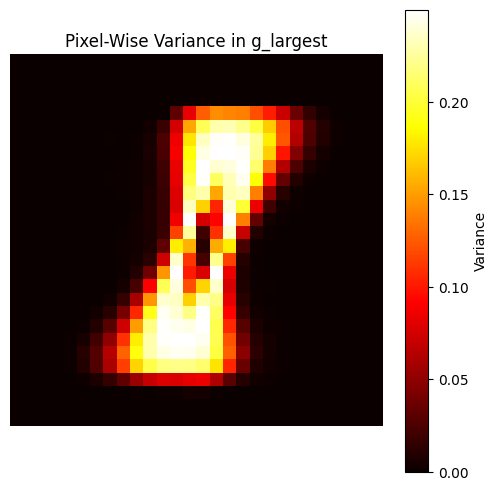

In [33]:
import numpy as np
import matplotlib.pyplot as plt

def plot_variance_heatmap(variances):
    """
    Plot a heatmap of per-pixel variance over the 28x28 MNIST grid.
    Assumes `variances` is a (784,) array, where each entry corresponds to a pixel.
    """
    # Reshape into 28x28 grid
    heatmap = variances.reshape(28, 28)

    plt.figure(figsize=(6, 6))
    plt.imshow(heatmap, cmap='hot', interpolation='nearest')
    plt.title("Pixel-Wise Variance in g_largest")
    plt.colorbar(label='Variance')
    plt.axis('off')
    plt.show()
plot_variance_heatmap(np.var(vectors_np[g_largest.vs.indices], axis=0))


Found 226 visible points


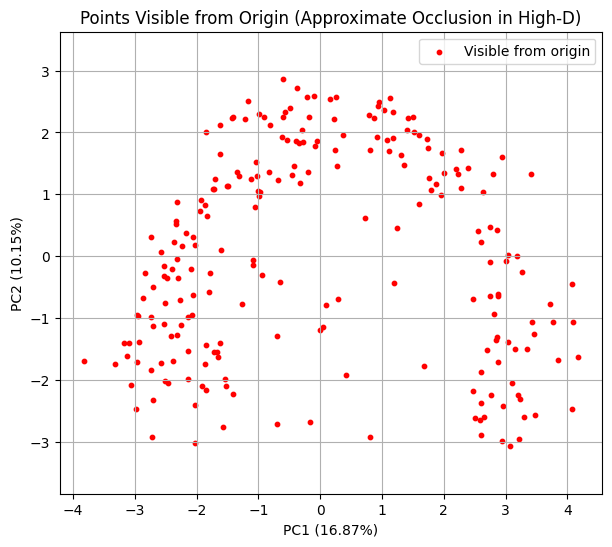

Explained variance by PCA components:
PC1: 16.8657%
PC2: 10.1523%
PC3: 6.3979%
PC4: 5.2584%
PC5: 4.5344%
PC6: 3.5767%
PC7: 2.9557%
PC8: 2.8490%
PC9: 2.6383%
PC10: 2.2756%


In [51]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def compute_visible_points_vectorized(vectors_np, num_directions=1000, angular_threshold=0.25):
    norms = np.linalg.norm(vectors_np, axis=1)
    unit_vectors = vectors_np / norms[:, None]  # shape (N, D)

    rand_dirs = np.random.randn(num_directions, vectors_np.shape[1])
    rand_dirs /= np.linalg.norm(rand_dirs, axis=1, keepdims=True)  # shape (num_directions, D)

    # Compute dot product matrix: (num_directions, N)
    dot_matrix = rand_dirs @ unit_vectors.T

    # Threshold mask: directions x points
    threshold_mask = dot_matrix > (1 - angular_threshold)

    # Initialize list of best indices
    visible_indices = set()

    for i in range(num_directions):
        candidate_mask = threshold_mask[i]
        if np.any(candidate_mask):
            candidate_indices = np.where(candidate_mask)[0]
            min_idx = candidate_indices[np.argmin(norms[candidate_indices])]
            visible_indices.add(min_idx)

    return list(visible_indices)


def plot_visible_vs_all(vectors_np, visible_indices):
    visible_vectors = vectors_np[visible_indices]
    all_vectors = vectors_np

    pca = PCA()
    # proj_all = pca.fit_transform(all_vectors)
    # proj_visible = pca.transform(visible_vectors)
    proj_visible = pca.fit_transform(visible_vectors)

    explained_var = pca.explained_variance_ratio_

    plt.figure(figsize=(7, 6))
    # plt.scatter(proj_all[:, 0], proj_all[:, 1], alpha=0.1, label='All points', color='gray')
    plt.scatter(proj_visible[:, 0], proj_visible[:, 1], alpha=1.0, label='Visible from origin', color='red', s=10)
    plt.legend()
    plt.title("Points Visible from Origin (Approximate Occlusion in High-D)")
    plt.xlabel(f"PC1 ({explained_var[0]*100:.2f}%)")
    plt.ylabel(f"PC2 ({explained_var[1]*100:.2f}%)")
    plt.grid(True)
    plt.axis('equal')
    plt.show()

    print("Explained variance by PCA components:")
    for i, v in enumerate(explained_var[:10]):
        print(f"PC{i+1}: {v*100:.4f}%")

# Run on current available vectors
visible_indices = compute_visible_points_vectorized(vectors_np, angular_threshold=0.95)
print(f"Found {len(visible_indices)} visible points")
plot_visible_vs_all(vectors_np, visible_indices)